In [1]:
# Install required packages
!pip install -q jax jaxlib
!pip install -q segyio matplotlib seaborn
!pip install -q xarray scipy numpy

# Clone SeisJAX repository (replace with actual repository URL)
!git clone https://github.com/atwahsz/SeisJAX.git
%cd SeisJAX
!pip install -e .


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 7.4 MB/s eta 0:00:00
Cloning into 'SeisJAX'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 68 (delta 27), reused 53 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 1.14 MiB | 3.23 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/SeisJAX
Obtaining file:///content/SeisJAX
  Preparing metadata (setup.py) ... done
  Running setup.py develop for seisjax


In [2]:
# Import required libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import segyio
import warnings
warnings.filterwarnings('ignore')

# JAX imports
import jax
import jax.numpy as jnp

# SeisJAX imports
import seisjax
from seisjax import utils

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"🚀 JAX version: {jax.__version__}")
print(f"🔥 JAX backend: {jax.default_backend()}")
print(f"📊 Available devices: {jax.devices()}")
print(f"⚡ SeisJAX version: {seisjax.__version__}")


🚀 JAX version: 0.5.2
🔥 JAX backend: gpu
📊 Available devices: [CudaDevice(id=0)]
⚡ SeisJAX version: 0.1.0


In [3]:
!cd "/content"
# Download Kerry3D dataset
!wget -q http://s3.amazonaws.com/open.source.geoscience/open_data/newzealand/Taranaiki_Basin/Keri_3D/Kerry3D.segy

print("✅ Kerry3D dataset downloaded successfully!")
!ls -lh Kerry3D.segy


✅ Kerry3D dataset downloaded successfully!
-rw-r--r-- 1 root root 1.1G Aug 19  2014 Kerry3D.segy


📖 Loading /content/Kerry3D.segy with manual reshape...
   📏 Total traces: 210,945
   📏 Samples per trace: 1,252
   ⏱️  Sample rate: 0.004 s
   📦 Loaded flat data shape: (210945, 1252)
   📊 Reshaped to volume: (287, 735, 1252)
   🔽 Subsampling: inlines x2, crosslines x2
   📊 Final volume shape: (144, 368, 1252)

⏱️  Data loaded in 3.68 seconds
📊 Final volume shape: (144, 368, 1252)
💾 Memory usage: ~253.1 MB


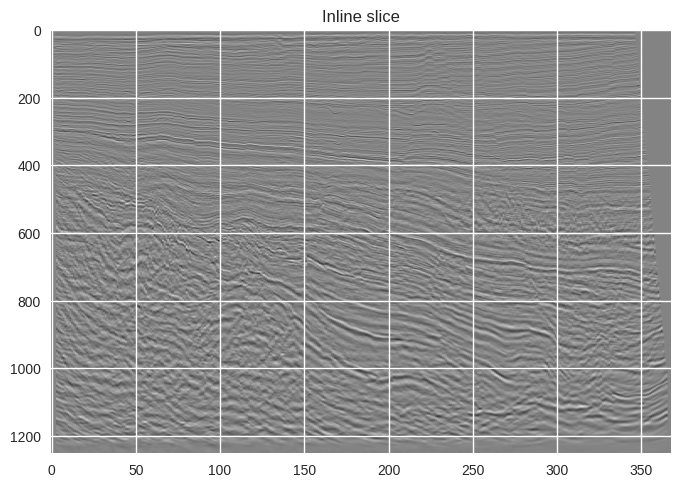

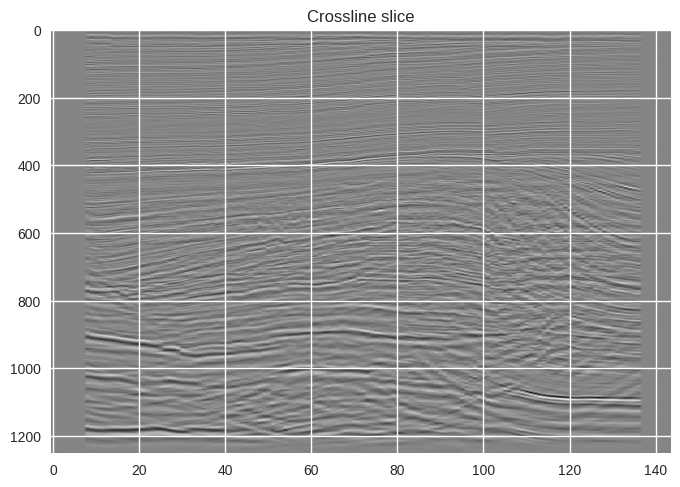

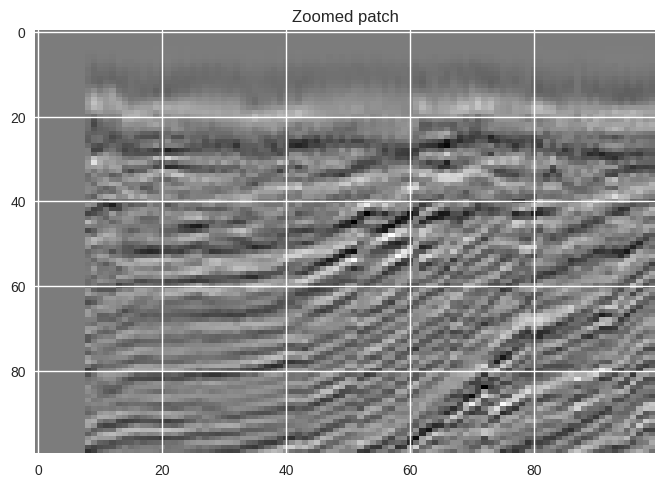

In [3]:
import segyio
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import time

def load_kerry3d_manual(filename, inline_dim=287, crossline_dim=735, subsample_inline=1, subsample_crossline=1):
    """
    Load Kerry3D seismic data by reading raw traces and reshaping manually.
    """
    print(f"📖 Loading {filename} with manual reshape...")

    with segyio.open(filename, "r", ignore_geometry=True) as f:
        n_traces = len(f.trace)
        n_samples = len(f.samples)
        dt = segyio.tools.dt(f) / 1e6  # microseconds to seconds

        print(f"   📏 Total traces: {n_traces:,}")
        print(f"   📏 Samples per trace: {n_samples:,}")
        print(f"   ⏱️  Sample rate: {dt:.3f} s")

        # Read all traces
        data_flat = f.trace.raw[:]
        print(f"   📦 Loaded flat data shape: {data_flat.shape}")

        # Reshape to known dimensions
        volume = np.reshape(data_flat, (inline_dim, crossline_dim, n_samples))
        print(f"   📊 Reshaped to volume: {volume.shape}")

        # Subsample
        volume_sub = volume[::subsample_inline, ::subsample_crossline, :]

        print(f"   🔽 Subsampling: inlines x{subsample_inline}, crosslines x{subsample_crossline}")
        print(f"   📊 Final volume shape: {volume_sub.shape}")

        time_axis = f.samples * dt

        return {
            'volume': jnp.array(volume_sub),
            'time': jnp.array(time_axis),
            'dt': dt,
            'fs': 1.0 / dt,
            'shape': volume_sub.shape
        }


# 🔎 **Load data**
start_time = time.time()
kerry_data = load_kerry3d_manual('/content/Kerry3D.segy', inline_dim=287, crossline_dim=735, subsample_inline=2, subsample_crossline=2)
load_time = time.time() - start_time

print(f"\n⏱️  Data loaded in {load_time:.2f} seconds")
print(f"📊 Final volume shape: {kerry_data['shape']}")
print(f"💾 Memory usage: ~{kerry_data['volume'].nbytes / 1024**2:.1f} MB")


# ✅ **Visualizations**
volume = np.array(kerry_data['volume'])

plt.figure()
plt.imshow(volume[volume.shape[0]//2, :, :].T, cmap='gray', aspect='auto')
plt.title("Inline slice")
plt.axis('tight')

plt.figure()
plt.imshow(volume[:, volume.shape[1]//2, :].T, cmap='gray', aspect='auto')
plt.title("Crossline slice")
plt.axis('tight')

plt.figure()
plt.imshow(volume[0:100, volume.shape[1]//2, 0:100].T, cmap='gray', aspect='auto')
plt.title("Zoomed patch")
plt.axis('tight')

plt.show()


📈 Seismic Volume Statistics:
   min: -12.205
   max: 11.679
   mean: -0.000
   std: 1.109
   shape: (144, 368, 1252)
   dtype: float32


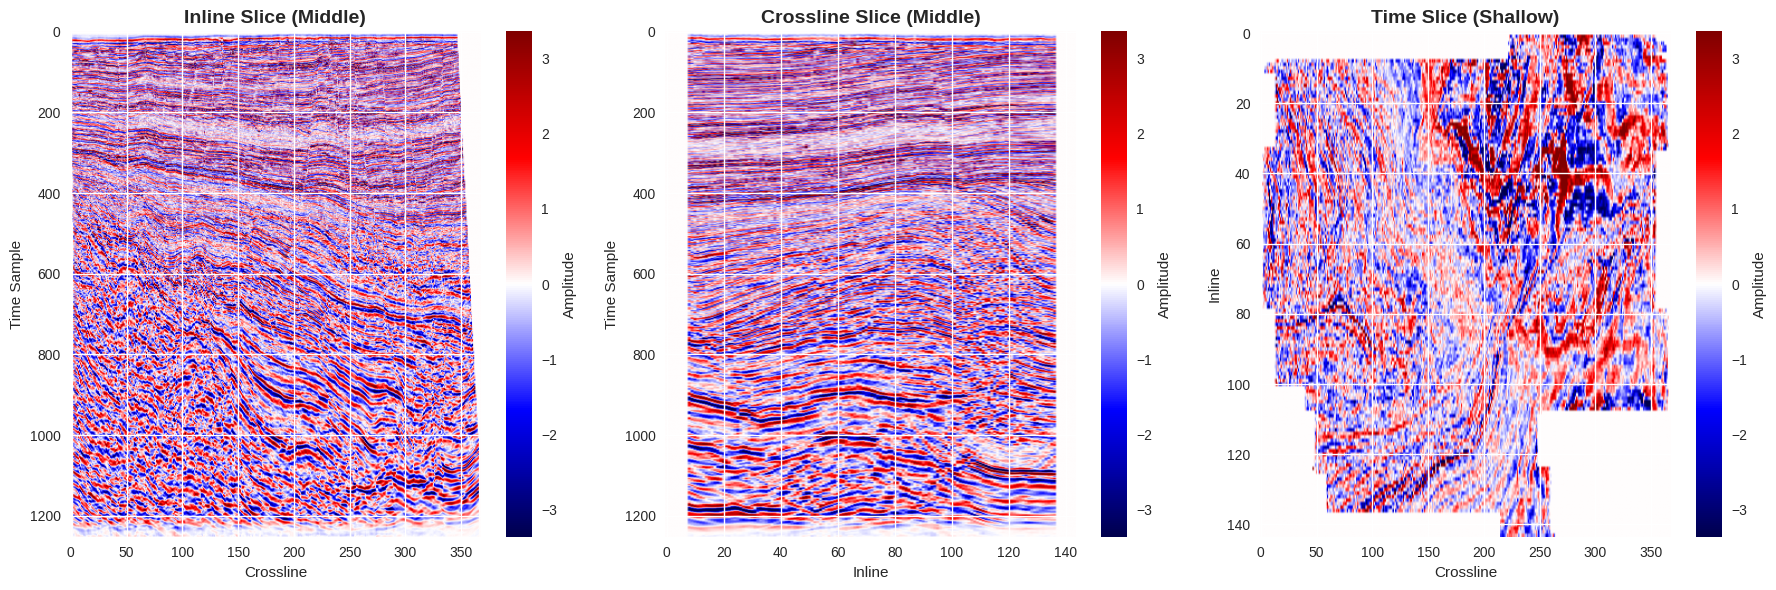

✅ Data preview saved as 'kerry3d_preview.png'


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ Calculate statistics function
def calculate_statistics(volume):
    """
    Compute basic statistics for a 3D seismic volume.
    Returns a dict of stats.
    """
    stats = {
        'min': float(np.nanmin(volume)),
        'max': float(np.nanmax(volume)),
        'mean': float(np.nanmean(volume)),
        'std': float(np.nanstd(volume)),
        'shape': volume.shape,
        'dtype': str(volume.dtype)
    }
    return stats

# ✅ Extract slice function
def extract_slice(volume, slice_type, index):
    """
    Extract a specific slice from volume.
    slice_type: 'inline', 'crossline', or 'time'
    """
    if slice_type == 'inline':
        return volume[index, :, :]
    elif slice_type == 'crossline':
        return volume[:, index, :]
    elif slice_type == 'time':
        return volume[:, :, index]
    else:
        raise ValueError("Invalid slice_type. Use 'inline', 'crossline', or 'time'.")

# 🔎 **Run the statistics and plotting**

volume = np.array(kerry_data['volume'])  # Ensure it's numpy

# Calculate stats
stats = calculate_statistics(volume)

print("📈 Seismic Volume Statistics:")
for key, value in stats.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.3f}")
    else:
        print(f"   {key}: {value}")

# Determine amplitude clip for visualization (99th percentile)
clip = np.percentile(np.abs(volume), 99)
vmin, vmax = -clip, clip

# Create preview plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Inline slice
inline_slice = extract_slice(volume, 'inline', volume.shape[0]//2)
im1 = axes[0].imshow(inline_slice.T, aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
axes[0].set_title('Inline Slice (Middle)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Crossline')
axes[0].set_ylabel('Time Sample')
plt.colorbar(im1, ax=axes[0], label='Amplitude')

# Crossline slice
crossline_slice = extract_slice(volume, 'crossline', volume.shape[1]//2)
im2 = axes[1].imshow(crossline_slice.T, aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
axes[1].set_title('Crossline Slice (Middle)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Inline')
axes[1].set_ylabel('Time Sample')
plt.colorbar(im2, ax=axes[1], label='Amplitude')

# Time slice
time_slice = extract_slice(volume, 'time', volume.shape[2]//3)
im3 = axes[2].imshow(time_slice, aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
axes[2].set_title('Time Slice (Shallow)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Crossline')
axes[2].set_ylabel('Inline')
plt.colorbar(im3, ax=axes[2], label='Amplitude')

plt.tight_layout()
plt.savefig('kerry3d_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Data preview saved as 'kerry3d_preview.png'")


🔥 Computing Complex Trace Attributes with JAX...
✅ Using SeisJAX version: 0.1.0
Computing envelope...
Computing instantaneous phase...
Computing instantaneous frequency...
Computing cosine instantaneous phase...
⏱️  Complex trace attributes computed in 1.007 seconds
📊 Envelope range: [0.0, 15.6]
📊 Instantaneous frequency range: [-125.0, 125.0] Hz


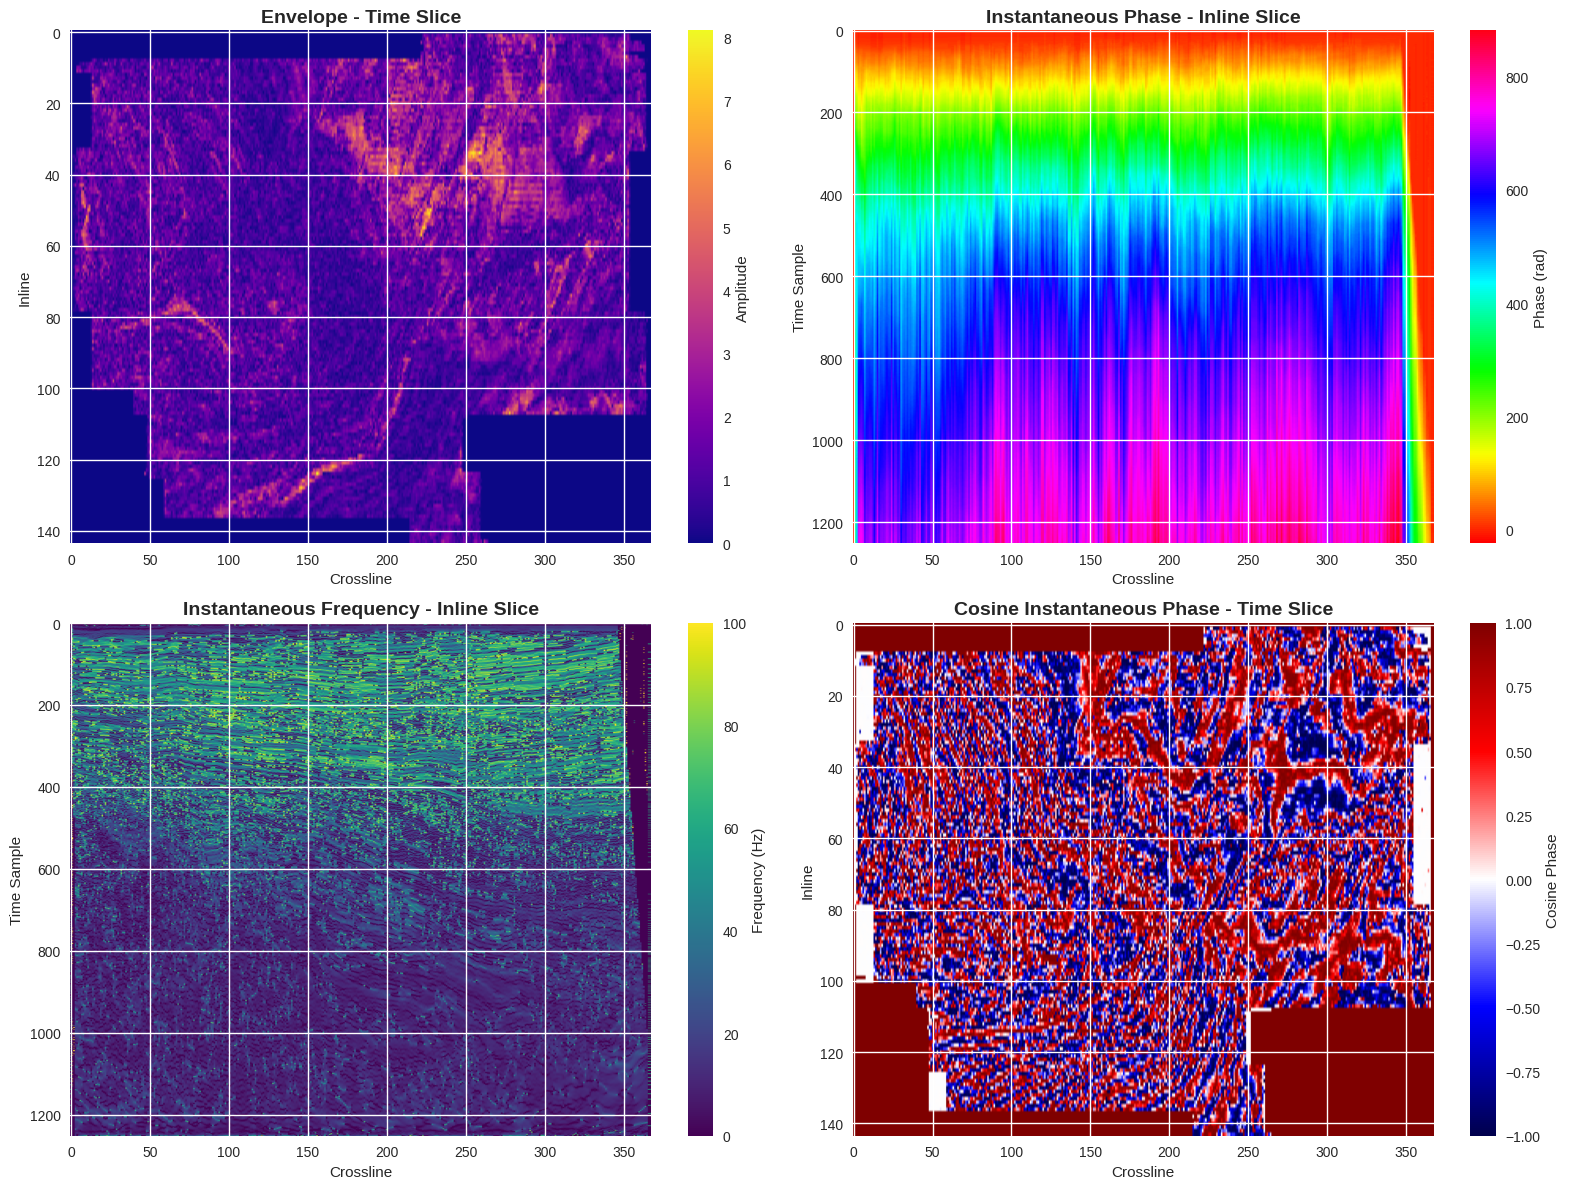

✅ Complex trace attributes visualization saved!


In [13]:
print("🔥 Computing Complex Trace Attributes with JAX...")

# Import fresh SeisJAX after our fixes
import seisjax
print(f"✅ Using SeisJAX version: {seisjax.__version__}")

# Time the computation
start_time = time.time()

# Compute complex trace attributes along time axis (axis=2)
# For Kerry3D data: axis=2 is time, axis=0 is inline, axis=1 is crossline
print("Computing envelope...")
envelope_vol = seisjax.envelope(volume, axis=2)

print("Computing instantaneous phase...")
inst_phase_vol = seisjax.instantaneous_phase(volume, axis=2)

print("Computing instantaneous frequency...")
inst_freq_vol = seisjax.instantaneous_frequency(volume, axis=2, fs=kerry_data['fs'])

print("Computing cosine instantaneous phase...")
cosine_phase_vol = seisjax.cosine_instantaneous_phase(volume, axis=2)

complex_attr_time = time.time() - start_time

print(f"⏱️  Complex trace attributes computed in {complex_attr_time:.3f} seconds")
print(f"📊 Envelope range: [{jnp.min(envelope_vol):.1f}, {jnp.max(envelope_vol):.1f}]")
print(f"📊 Instantaneous frequency range: [{jnp.min(inst_freq_vol):.1f}, {jnp.max(inst_freq_vol):.1f}] Hz")

# Visualize complex trace attributes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Envelope - Time slice
env_slice = envelope_vol[:, :, volume.shape[2]//3]
im1 = axes[0, 0].imshow(env_slice, aspect='auto', cmap='plasma')
axes[0, 0].set_title('Envelope - Time Slice', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Crossline')
axes[0, 0].set_ylabel('Inline')
plt.colorbar(im1, ax=axes[0, 0], label='Amplitude')

# Instantaneous Phase - Inline slice
phase_slice = inst_phase_vol[volume.shape[0]//2, :, :]
im2 = axes[0, 1].imshow(phase_slice.T, aspect='auto', cmap='hsv')
axes[0, 1].set_title('Instantaneous Phase - Inline Slice', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Crossline')
axes[0, 1].set_ylabel('Time Sample')
plt.colorbar(im2, ax=axes[0, 1], label='Phase (rad)')

# Instantaneous Frequency - Inline slice
freq_slice = inst_freq_vol[volume.shape[0]//2, :, :]
im3 = axes[1, 0].imshow(freq_slice.T, aspect='auto', cmap='viridis', vmin=0, vmax=100)
axes[1, 0].set_title('Instantaneous Frequency - Inline Slice', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Crossline')
axes[1, 0].set_ylabel('Time Sample')
plt.colorbar(im3, ax=axes[1, 0], label='Frequency (Hz)')

# Cosine Instantaneous Phase - Time slice
cos_phase_slice = cosine_phase_vol[:, :, volume.shape[2]//3]
im4 = axes[1, 1].imshow(cos_phase_slice, aspect='auto', cmap='seismic')
axes[1, 1].set_title('Cosine Instantaneous Phase - Time Slice', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Crossline')
axes[1, 1].set_ylabel('Inline')
plt.colorbar(im4, ax=axes[1, 1], label='Cosine Phase')

plt.tight_layout()
plt.savefig('complex_trace_attributes.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Complex trace attributes visualization saved!")


🎵 Computing Spectral Decomposition with JAX...
Computing dominant frequency...
Computing spectral centroid...
Computing spectral bandwidth...
Computing RGB frequency blend...
⏱️  Spectral attributes computed in 0.182 seconds
📊 Dominant frequency range: [0.0, 70.3] Hz
📊 Spectral centroid range: [0.0, 61.4] Hz


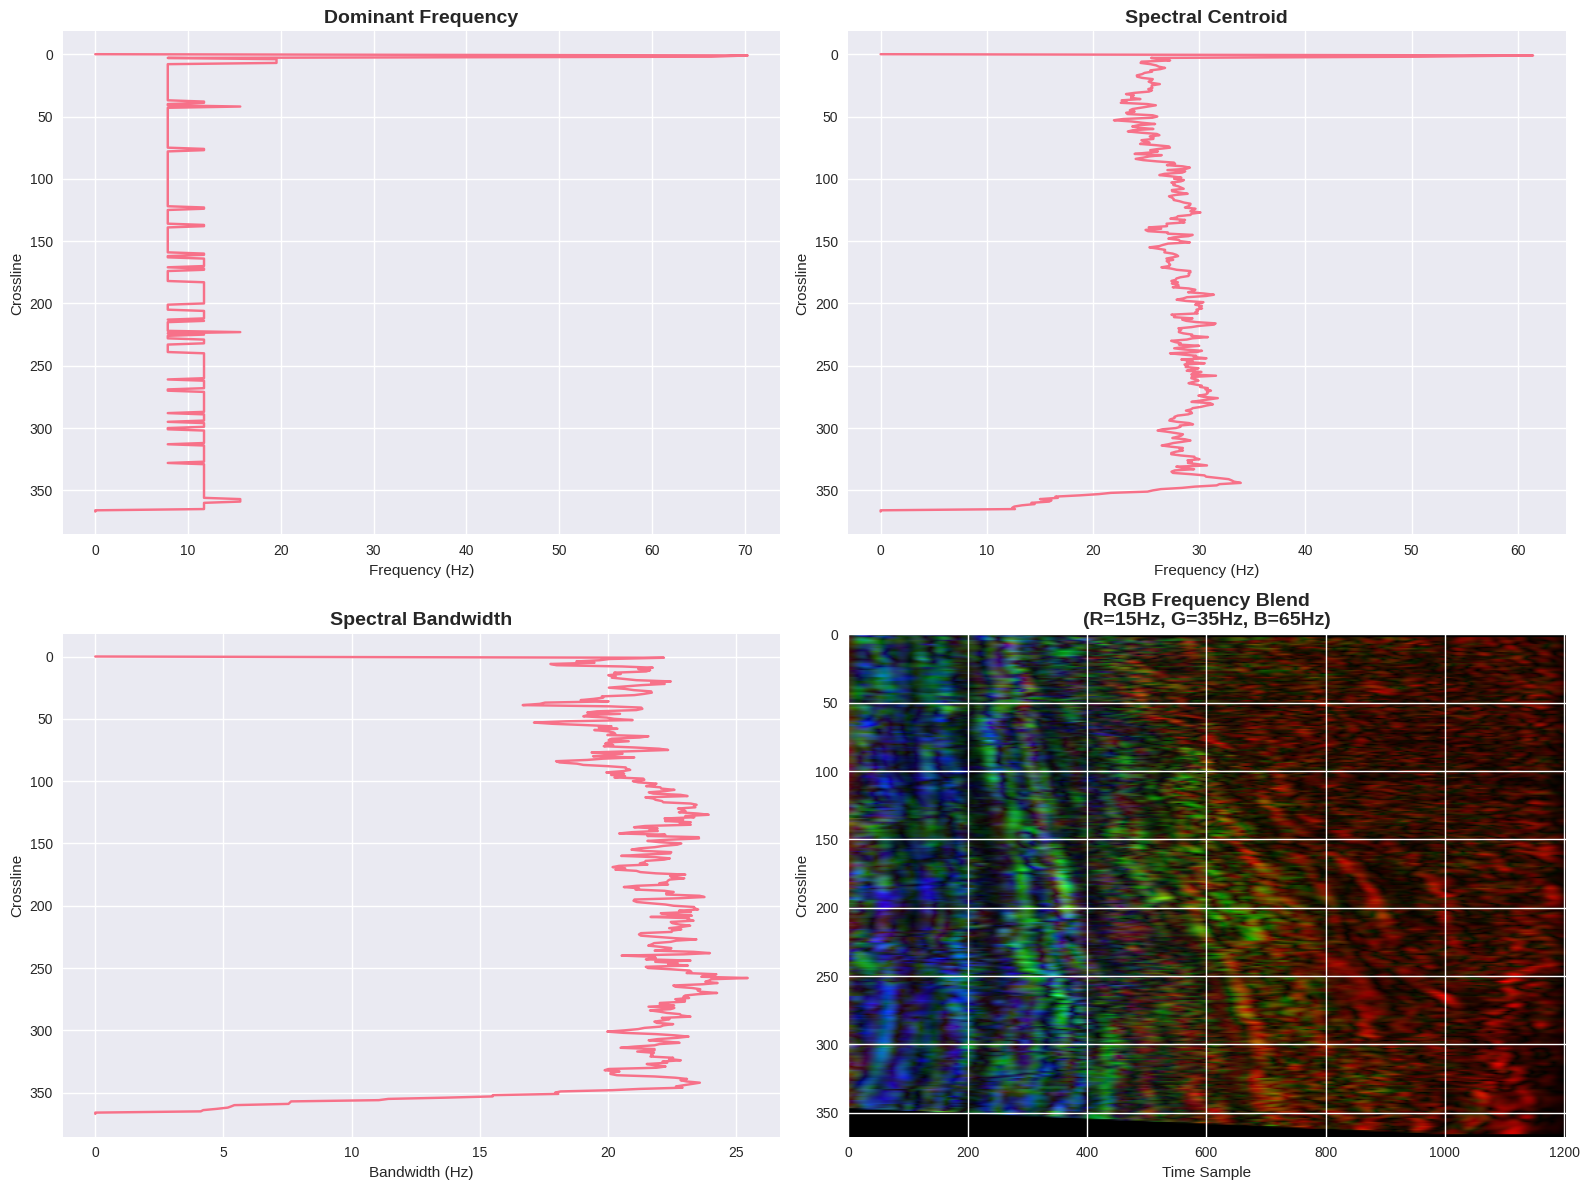

✅ Spectral attributes visualization saved!


In [10]:
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

print("🎵 Computing Spectral Decomposition with JAX...")

# Time the computation
start_time = time.time()

# Extract a single inline for spectral decomposition (too computationally intensive for full volume)
test_inline = volume[volume.shape[0]//2, :, :]

# Ensure test_inline is a jax array
test_inline_jax = jnp.array(test_inline)

# Compute spectral attributes using axis=1 (time axis for the 2D slice)
# For test_inline: axis=0 is crossline, axis=1 is time
print("Computing dominant frequency...")
dom_freq = seisjax.dominant_frequency(test_inline_jax, axis=1, fs=kerry_data['fs'])

print("Computing spectral centroid...")
spec_centroid = seisjax.spectral_centroid(test_inline_jax, axis=1, fs=kerry_data['fs'])

print("Computing spectral bandwidth...")
spec_bandwidth = seisjax.spectral_bandwidth(test_inline_jax, axis=1, fs=kerry_data['fs'])

print("Computing RGB frequency blend...")
rgb_blend = seisjax.rgb_frequency_blend(
    test_inline_jax,
    fs=kerry_data['fs'],
    freq_red=15.0,
    freq_green=35.0,
    freq_blue=65.0,
    axis=1
)

spectral_time = time.time() - start_time

print(f"⏱️  Spectral attributes computed in {spectral_time:.3f} seconds")
print(f"📊 Dominant frequency range: [{jnp.min(dom_freq):.1f}, {jnp.max(dom_freq):.1f}] Hz")
print(f"📊 Spectral centroid range: [{jnp.min(spec_centroid):.1f}, {jnp.max(spec_centroid):.1f}] Hz")

# Convert JAX arrays to numpy for plotting
dom_freq_np = np.array(dom_freq)
spec_centroid_np = np.array(spec_centroid)
spec_bandwidth_np = np.array(spec_bandwidth)
rgb_blend_np = np.array(rgb_blend)

# Visualize spectral attributes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Dominant frequency (1D) line plot
axes[0, 0].plot(dom_freq_np, np.arange(len(dom_freq_np)))
axes[0, 0].invert_yaxis()
axes[0, 0].set_title('Dominant Frequency', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Crossline')

# Spectral centroid (1D) line plot
axes[0, 1].plot(spec_centroid_np, np.arange(len(spec_centroid_np)))
axes[0, 1].invert_yaxis()
axes[0, 1].set_title('Spectral Centroid', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Crossline')

# Spectral bandwidth (1D) line plot
axes[1, 0].plot(spec_bandwidth_np, np.arange(len(spec_bandwidth_np)))
axes[1, 0].invert_yaxis()
axes[1, 0].set_title('Spectral Bandwidth', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Bandwidth (Hz)')
axes[1, 0].set_ylabel('Crossline')

# RGB frequency blend (2D) image plot
if rgb_blend_np.ndim == 3:
    axes[1, 1].imshow(rgb_blend_np, aspect='auto')
    axes[1, 1].set_title('RGB Frequency Blend\n(R=15Hz, G=35Hz, B=65Hz)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Time Sample')
    axes[1, 1].set_ylabel('Crossline')
else:
    axes[1, 1].text(0.5, 0.5, "RGB blend output invalid shape", ha='center', va='center')

plt.tight_layout()
plt.savefig('spectral_attributes.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Spectral attributes visualization saved!")


🧪 Test volume shape: (20, 20, 200)

🔥 Benchmarking Envelope Computation:
   JAX time: 0.0024 seconds
   NumPy time: 0.0079 seconds
   🚀 Speedup: 3.3x

📡 Benchmarking Instantaneous Frequency Computation:
   JAX time: 0.0054 seconds
   NumPy time: 0.0046 seconds
   🚀 Speedup: 0.8x


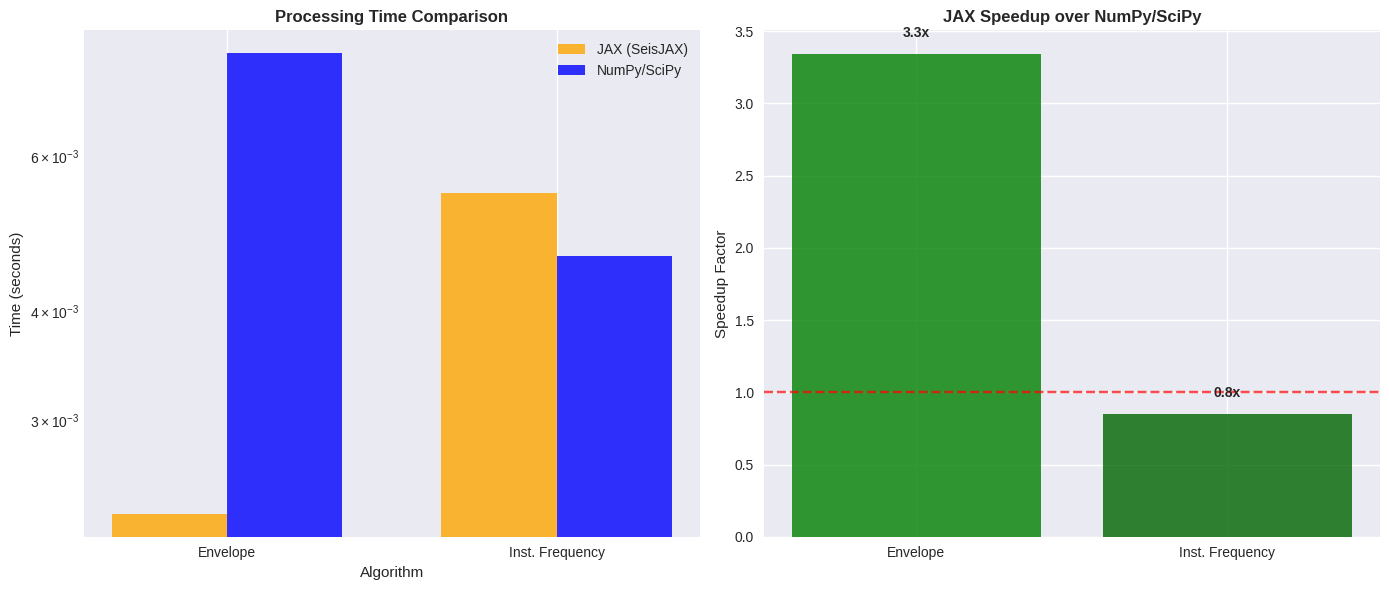


🏆 Overall Results:
   💻 Hardware: gpu
   📊 Average speedup: 2.1x
   🚀 SeisJAX enables real-time seismic attribute computation!
✅ Performance benchmark visualization saved!


In [7]:
import scipy.signal

def numpy_envelope(x):
    """Traditional NumPy/SciPy envelope computation."""
    analytic = scipy.signal.hilbert(x, axis=-1)
    return np.abs(analytic)

def numpy_inst_freq(x, fs=1.0):
    """Traditional NumPy/SciPy instantaneous frequency computation."""
    analytic = scipy.signal.hilbert(x, axis=-1)
    inst_phase = np.unwrap(np.angle(analytic), axis=-1)
    return (fs / (2 * np.pi)) * np.gradient(inst_phase, axis=-1)

# Prepare test data (smaller subset for fair comparison)
test_volume = np.array(volume[:20, :20, :200])  # Smaller subset
print(f"🧪 Test volume shape: {test_volume.shape}")

# Benchmark envelope computation
print("\n🔥 Benchmarking Envelope Computation:")

# JAX version (with JIT warm-up)
jax_test_vol = jnp.array(test_volume)
_ = seisjax.envelope(jax_test_vol, axis=-1)  # Warm-up JIT

start_time = time.time()
jax_envelope = seisjax.envelope(jax_test_vol, axis=-1)
jax_time = time.time() - start_time

# NumPy version
start_time = time.time()
numpy_envelope_result = numpy_envelope(test_volume)
numpy_time = time.time() - start_time

print(f"   JAX time: {jax_time:.4f} seconds")
print(f"   NumPy time: {numpy_time:.4f} seconds")
print(f"   🚀 Speedup: {numpy_time/jax_time:.1f}x")

# Benchmark instantaneous frequency computation
print("\n📡 Benchmarking Instantaneous Frequency Computation:")

# JAX version (with JIT warm-up)
_ = seisjax.instantaneous_frequency(jax_test_vol, axis=-1, fs=kerry_data['fs'])  # Warm-up

start_time = time.time()
jax_freq = seisjax.instantaneous_frequency(jax_test_vol, axis=-1, fs=kerry_data['fs'])
jax_freq_time = time.time() - start_time

# NumPy version
start_time = time.time()
numpy_freq = numpy_inst_freq(test_volume, fs=kerry_data['fs'])
numpy_freq_time = time.time() - start_time

print(f"   JAX time: {jax_freq_time:.4f} seconds")
print(f"   NumPy time: {numpy_freq_time:.4f} seconds")
print(f"   🚀 Speedup: {numpy_freq_time/jax_freq_time:.1f}x")

# Create performance comparison chart
algorithms = ['Envelope', 'Inst. Frequency']
jax_times = [jax_time, jax_freq_time]
numpy_times = [numpy_time, numpy_freq_time]
speedups = [numpy_time/jax_time, numpy_freq_time/jax_freq_time]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Time comparison
x = np.arange(len(algorithms))
width = 0.35

ax1.bar(x - width/2, jax_times, width, label='JAX (SeisJAX)', color='orange', alpha=0.8)
ax1.bar(x + width/2, numpy_times, width, label='NumPy/SciPy', color='blue', alpha=0.8)
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Processing Time Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.legend()
ax1.set_yscale('log')

# Speedup comparison
bars = ax2.bar(algorithms, speedups, color=['green', 'darkgreen'], alpha=0.8)
ax2.set_ylabel('Speedup Factor')
ax2.set_title('JAX Speedup over NumPy/SciPy', fontweight='bold')
ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No speedup')

# Add speedup labels on bars
for bar, speedup in zip(bars, speedups):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{speedup:.1f}x', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('performance_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n🏆 Overall Results:")
print(f"   💻 Hardware: {jax.default_backend()}")
print(f"   📊 Average speedup: {np.mean(speedups):.1f}x")
print(f"   🚀 SeisJAX enables real-time seismic attribute computation!")
print(f"✅ Performance benchmark visualization saved!")
